In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.decomposition.asf import ASF
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.saver import load_checkpoint
from auto_robot_design.description.builder import  jps_graph2pinocchio_robot_3d_constraints
from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint
from auto_robot_design.utils.configs import get_standard_builder, get_standard_crag, get_standard_trajectories, get_standard_rewards, get_mesh_builder

In [2]:
MECH_FROM_OPTIMIZATION = False

Praise the Gods for ChatGPT that helps us to create simple way to make directory choosing interface.

In [3]:
if MECH_FROM_OPTIMIZATION:
    import tkinter as tk
    from tkinter import filedialog

    def select_directory():
        # Create a root window
        root = tk.Tk()
        # Hide the root window
        root.withdraw()
        # Make the root window the topmost window
        root.call('wm', 'attributes', '.', '-topmost', True)
        # Open directory dialog and store the selected directory path
        directory_path = filedialog.askdirectory(initialdir="./",
            title="Select a directory"
        )
        root.update_idletasks() 
        root.destroy()
        # Check if a directory was selected
        if directory_path:
            #print(f"Selected directory: {directory_path}")
            return directory_path
        else:
            #print("No directory selected")
            return None

    # Call the function to open the directory dialog
    selected_directory = select_directory()
    problem = MultiCriteriaProblem.load(
    selected_directory
    )

    checkpoint = load_checkpoint(selected_directory)
    optimizer = PymooOptimizer(problem, checkpoint)
    optimizer.load_history(selected_directory)
    res = optimizer.run()

I have no idea what happens here, but it appears to be a way to get a particular solution from Pareto front using the weights of the criteria  

In [4]:
WEIGHT = 0.5
if MECH_FROM_OPTIMIZATION:
    F = res.F
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    weights = np.array([WEIGHT, 1-WEIGHT])

    decomp = ASF()
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[b]
    graph = problem.graph_manager.get_graph(best_x)
    draw_joint_point(graph)

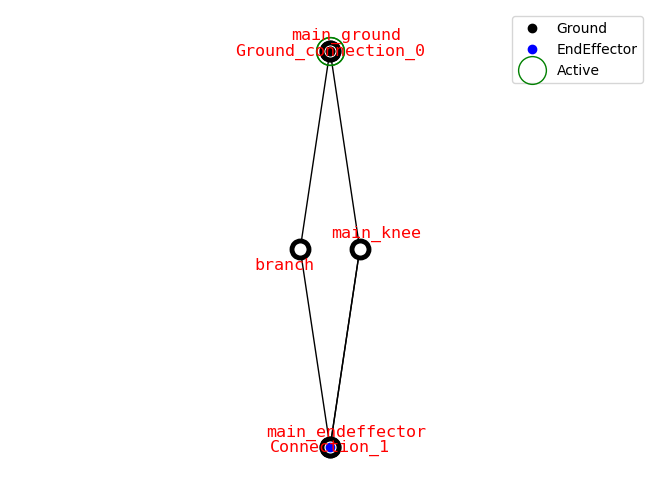

In [5]:

if not MECH_FROM_OPTIMIZATION:
    tp = TopologyManager2D()
    # creates ground connection
    tp.add_connection(ground=True, self_mutation_range= [(-0.2001, 0.1999),None,(-0.1, 0.1)], dependent_mutation_range=[(-0.13,0.07),None,(-0.3,-0.1)])
    main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
    tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))
    main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_knee', attach_ground=False, attach_endeffector=False)
    tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.03, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.03,0,None]))
    # creates connection on the first link
    tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])
    main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
    tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.4]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.4]))
    # creates connection on the second link
    tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.5, 0.3)], self_freeze_pos=[0.0,0,-0.4999], dependent_mutation_range=[(-0.2,0.0),None,(-0.0,0.2)])
    # creates branch node and one-joint branch in the topology manager. 
    branch_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=False, name='branch', attach_ground=False, attach_endeffector=False)
    tp.add_relative_node(branch_jp)
    # adds a dependent connection of the one-joint branch to the 
    tp.add_dependent_connection(0,1,connect_head=True)
    # adds independent connection to the second link finishing the branch building
    tp.add_independent_connection(tp.branch_ends[1][1],tp.connections[2].connection_jp)
    tp.set_mutation_ranges()
    tp.visualize()
    graph = tp.graph

The saved results includes the description of the rewards and trajectories, also the soft constrain part.  
A simple visualization of trajectories and mech.

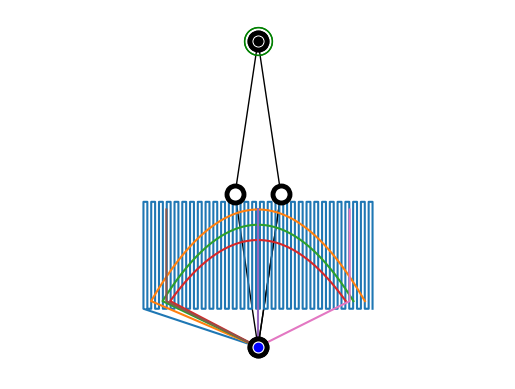

In [6]:

builder = get_standard_builder()
crag = get_standard_crag(open_loop=False)
trajectories = get_standard_trajectories()
rewards = get_standard_rewards()


for _, trajectory in trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

draw_joint_point(graph, draw_labels=False)
plt.show()

Builder and criterion aggregator can both be obtained from the saved data.

In [7]:
print(trajectories.keys())
print(rewards.keys())

dict_keys(['workspace', 'step1', 'step2', 'step3', 'central_vertical', 'left_vertical', 'right_vertical'])
dict_keys(['mass', 'actuated_inertia_matrix', 'z_imf', 'trajectory_manipulability', 'manipulability', 'min_manipulability', 'min_force', 'trajectory_zrr', 'dexterity', 'trajectory_acceleration', 'min_acceleration', 'mean_heavy_lifting', 'min_heavy_lifting'])


One can get a trajectory from the reward manager and calculate the trajectory following data.

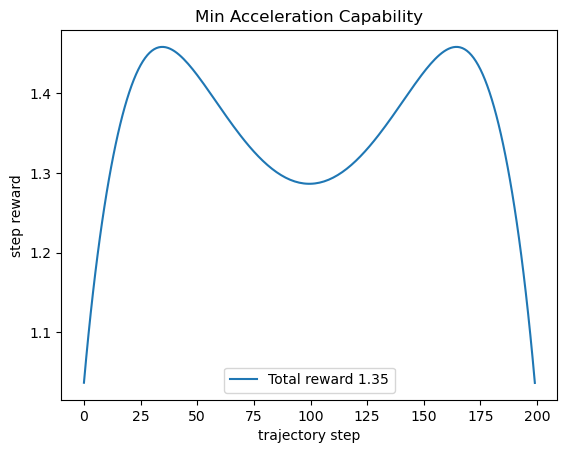

In [12]:
trajectory_name = 'step1'
reward_name = 'min_acceleration'
trajectory = trajectories[trajectory_name]
error_calculator = PositioningErrorCalculator(jacobian_key="Manip_Jacobian")
soft_constraint = PositioningConstrain(error_calculator=error_calculator, points=[trajectory])
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
constraint_error, results = soft_constraint.calculate_constrain_error(crag, fixed_robot, free_robot)
results = results[0]
if constraint_error == 0:
    reward, reward_list = rewards[reward_name].calculate(results[0], results[1], results[2], Actuator = builder.actuator['default'])
    reward_vector = np.array(reward_list)
    plt.plot(reward_vector)
    plt.xlabel('trajectory step')
    plt.ylabel('step reward')
    plt.title(rewards[reward_name].reward_name)
    plt.legend([f'Total reward {round(reward,2)}'])
    plt.show()
else:
    print("Trajectory not feasible: ", constraint_error)

In [9]:
results[0]['Manip_Jacobian'][-1]
np.linalg.eigvals(results[0]['Manip_Jacobian'][-1])
np.linalg.svd(results[0]['Manip_Jacobian'][-1],compute_uv=False)

array([0.25993857, 0.11916693], dtype=float32)

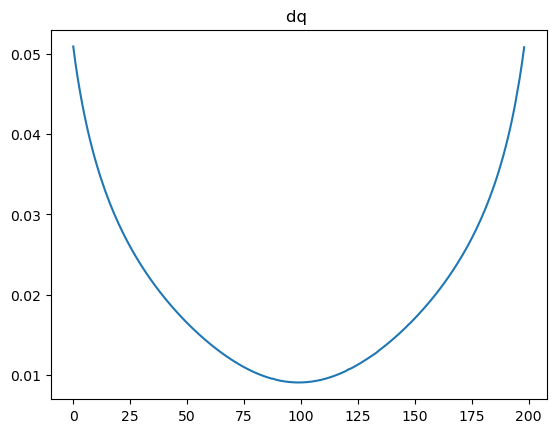

In [10]:
plt.plot(np.linalg.norm(np.diff(results[2]['q'], axis=0),axis=1))
plt.title('dq ')
plt.show()

In [11]:
import ipywidgets as widgets
import meshcat
from pinocchio.visualize import MeshcatVisualizer
from IPython.display import display, clear_output, HTML, IFrame, Image
from auto_robot_design.description.mesh_builder.urdf_creater import (
    URDFMeshCreator,
    MeshCreator,
)
from auto_robot_design.description.mesh_builder.mesh_builder import (
    MeshBuilder,
    jps_graph2pinocchio_meshes_robot,
)
import pinocchio as pin
import time
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager


mesh_builder = get_mesh_builder()
output = widgets.Output()

fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(graph, mesh_builder)
visualizer = MeshcatVisualizer(
    fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model
)
with output:
    visualizer.viewer = meshcat.Visualizer()
visualizer.viewer["/Background"].set_property("visible", False)
visualizer.viewer["/Grid"].set_property("visible", False)
visualizer.viewer["/Axes"].set_property("visible", False)
visualizer.viewer["/Cameras/default/rotated/<object>"].set_property(
    "position", [0, 0.0, 0.8]
)
visualizer.clean()
visualizer.loadViewerModel()
visualizer.display(pin.neutral(fixed_robot.model))
with output:
    output.clear_output(wait=True)
    display(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

#output.append_display_data(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

def run_simulation(b):
    ik_manager = TrajectoryIKManager()
    ik_manager.set_solver('Open_Loop')
    # fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph, builder)
    fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(graph, mesh_builder)
    ik_manager.register_model(
        fixed_robot.model, fixed_robot.constraint_models, fixed_robot.visual_model
    )
    #ik_manager.set_solver("Closed_Loop_PI")
    poses, q_fixed, constraint_errors, reach_array = ik_manager.follow_trajectory(
        trajectory, viz=visualizer
    )
    time.sleep(0.5)
    visualizer.display(pin.neutral(fixed_robot.model))

first_run_button = widgets.Button(description='run simulation', layout=widgets.Layout(width='200px', height='40px')) 
first_run_button.style.button_color = 'lightblue'
first_run_button.on_click(run_simulation)
display(output, first_run_button)

Output()

Button(description='run simulation', layout=Layout(height='40px', width='200px'), style=ButtonStyle(button_col…